# Experiment: Business Process Drift - (Maaradji - Fast)

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pm4py
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from sklearn.model_selection import ParameterGrid

from tqdm.notebook import tqdm_notebook
import time
from matplotlib.backends.backend_pdf import PdfPages
from joblib import Parallel, delayed

sys.path.append("../Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(threshold=sys.maxsize)


## Function to run the class TMPD pipeline in parallel

In [2]:
def run_pipeline_TMPD(kwargs, display=False):
    # log_path
    # , case_id, activity_key, timestamp_key
    # , window_size_mode, window_size, window_ref_mode, overlap, sliding_step
    # , threshold_anomaly, control_flow_features, time_features, resource_features, data_features
    # , change_features_strategy_dict
    # , detection_task_strategy_dict, margin_error

    ### Loading event log
    # Extracting event log
    event_log = TMPD_utils.parse_mxml(kwargs['log_path'])

    # This is a specifc step. This event log separate in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
    event_log = event_log[event_log.EventType == "complete"]

    # This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
    event_log = event_log[event_log.EventType == "complete"]

    # Save original event index
    event_log = event_log.reset_index(names='original_index') 

    # Create an id based on the order of the event in the raw event log
    event_log["Event_order_id"] = event_log.index

    # This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
    event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["TraceId"])

    # Showing loaded event log
    # event_log.head(15)


    ### Step 1 - Instantiating class and setting event log
    print('step 1')
    # Iniatializing the TMPD_class
    TMPD_instance = TMPD_class.TMPD(scenario='offline')

    # Setting the transition log
    TMPD_instance.set_transition_log(event_log, case_id = kwargs['case_id'], activity_key = kwargs['activity_key'], timestamp_key = kwargs['timestamp_key'])

    # Executing the transition log
    TMPD_instance.run_transition_log()

    # Showing the transition log created
    # TMPD_instance.get_transition_log().head(15)

    
    ### Step 2 - Setting Window Strategy
    print('step 2')
    # Setting the window strategy parameters
    TMPD_instance.set_windowing_strategy(window_size_mode = kwargs['window_size_mode'], window_size = kwargs['window_size'], window_ref_mode = kwargs['window_ref_mode']
                                            , overlap = kwargs['overlap'], sliding_step = kwargs['sliding_step'])

    # Executing the window strategy indexation
    TMPD_instance.run_windowing_strategy()

    # Showing the windows indexes
    # dict(list(TMPD_instance.get_windowing_strategy().items())[:15])


    ### Step 3 - Setting Process Representation (using Transition Matrix)
    print('step 3')
    # Setting the Transition Matrix (TM) process representation
    TMPD_instance.set_process_representation(threshold_anomaly = kwargs['threshold_anomaly']
                                        , control_flow_features = kwargs['control_flow_features']
                                        , time_features = kwargs['time_features']
                                        , resource_features = kwargs['resource_features']
                                        , data_features = kwargs['data_features'])

    # Executing the process_representation using all dataset just for an example
    # TMPD_instance.run_process_representation(TMPD_instance.transition_log)

    # Showing the process representation created
    # TMPD_instance.get_process_representation().head(15)


    ### Step 4 - Setting Change Representation
    print('step 4')
    # Setting Change Representation
    TMPD_instance.set_change_representation(kwargs['change_features_strategy_dict'])

    # Executing the Change Representation using the window strategy
    TMPD_instance.run_change_representation()

    # Showing the Change Representation created
    # TMPD_instance.get_change_representation().head(15)


    ### Step 5 - Setting Detection Task
    print('step 5')
    # Setting Detection Task
    TMPD_instance.set_detection_task(kwargs['detection_task_strategy_dict'])

    # Executing the Detection Task
    TMPD_instance.run_detection_task()

    # Getting Detection Task Results
    detection_task_results = TMPD_instance.get_detection_task()


    ### Defining Grounding truth
    print('Grounding truth')
    log_size = event_log['Trace_order'].nunique()
    ground_truth_traces_indexes = list(range(int(log_size/10), log_size, int(log_size/10)))

    transition_log = TMPD_instance.get_transition_log()
    ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

    # signals_indexes = signals.reset_index()
    signals = TMPD_instance.get_change_representation()
    ground_truth = []
    for ground_truth_events_index in ground_truth_events_indexes:
        ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                    & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
    ground_truth = ground_truth + [len(signals)]
    # print("ground_truth: ", ground_truth)

    ### Validation metrics
    print('Validation metrics')
    for index, row in detection_task_results.iterrows():
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        smooth = int(kwargs['detection_task_strategy_dict'][row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(kwargs['margin_error'] + 1)  if kwargs['overlap'] == False else int(kwargs['margin_error'] + 1 + kwargs['window_size']/kwargs['sliding_step'])

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay
        # print("F1: ", f1, " Delay: ", delay, " Precision: ", round(precision, 2), " Recall: ", round(recall, 2))


    ### Add informations to final result
    print('Adding informations')
    detection_task_results['log_path'] = kwargs['log_path']
    detection_task_results['tipo_mudanca'] = kwargs['log_path'].split("/")[-1].split("\\")[-2]
    detection_task_results['log_size'] = log_size
    detection_task_results['window_size_mode'] = kwargs['window_size_mode']
    detection_task_results['window_size'] = kwargs['window_size']
    detection_task_results['window_ref_mode'] = kwargs['window_ref_mode']
    detection_task_results['overlap'] = kwargs['overlap']
    detection_task_results['sliding_step'] = kwargs['sliding_step']
    detection_task_results['margin_error'] = kwargs['margin_error']
    detection_task_results['margin_error_corrected'] = margin_error


    ### Display results
    if display:
        print('Display results')
        display_list = []
        for index, result in detection_task_results.iterrows():
            print(ground_truth, result['detection_results'])
            fig, axarr = rpt.display(signal=TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result['detection_strategy']][result['detection_feature']]['change_features']]
                        , true_chg_pts=ground_truth
                        , computed_chg_pts=result['detection_results']
                        , computed_chg_pts_color="k"
                        , computed_chg_pts_linewidth=4
                        , computed_chg_pts_linestyle="--"
                        , computed_chg_pts_alpha=1
                        , figsize=(15, 3)
                        )
            plt.suptitle("Log: " + detection_task_results.loc[index, 'tipo_mudanca'] + " - size: " + str(detection_task_results.loc[index, 'log_size']) + 
                            " - F1: " + str(detection_task_results.loc[index, 'f1']) + " - Delay: " + str(detection_task_results.loc[index, 'delay']), fontsize=30)
            plt.subplots_adjust(top=0.8)
            
            with io.BytesIO() as buff:
                fig.savefig(buff, format='raw')
                buff.seek(0)
                data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
            w, h = fig.canvas.get_width_height()
            im = data.reshape((int(h), int(w), -1))
            display_list.append(im)

        detection_task_results['display'] = display_list

    
    # Deleting class instance
    del TMPD_instance

    # Returning detection results
    return detection_task_results

## Loading Business Process Drift - (Maaradji - Fast) event logs

In [3]:
# Mapping all event_logs paths
logs_path = glob.glob("../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs/*/*k.*")

# Removing the logs with 2500 events (based on Maaradji paper)
logs_path = [x for x in logs_path if "2.5" not in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  54


,0
0,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml
1,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb5k.mxml
2,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb7.5k.mxml
3,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd10k.mxml
4,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd5k.MXML
5,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd7.5k.MXML
6,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf10k.mxml
7,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf5k.mxml
8,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf7.5k.mxml
9,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cm\cm10k.mxml


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

## Experiment impacts of the parameters

### Define the Parameters GridSearch 

In [10]:
### Grid Search of parameters
TMPD_ParameterGrid = ParameterGrid({

    # Step 1 - Instantiating class and setting event log
    'case_id' : ['Trace_order']
    , 'activity_key' : ['Activity']
    , 'timestamp_key' : ['Timestamp']

    # Step 2 - Setting Window Strategy
    , 'window_size_mode' : ['Fixed']
    , 'window_size' : [1000, 2000, 4000]
    , 'window_ref_mode' : ['Fixed', 'Sliding']
    , 'overlap' : [False]
    , 'sliding_step' : [0]#[200, 500]

    # Step 3 - Setting Process Representation (using Transition Matrix)
    , 'threshold_anomaly': [0]
    , 'control_flow_features': [['frequency', 'probability']]
    , 'time_features': [{}]
    , 'resource_features': [{}]
    , 'data_features': [{}]

    # Step 4 - Setting Change Representation
    , 'change_features_strategy_dict' : [{
        'delta_matrix_strategy': 
            {
                'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
                , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
                , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            }
        , 'statistic_test_strategy' : 
            {
                'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            }
    }]
    
    # Step 5 - Setting Detection Task
    , 'detection_task_strategy_dict' :  [
        {
        'time_series_strategy': 
            {
                'cpd_frequency_delta1' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '1'}        
                , 'cpd_frequency_delta3' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '3'}
                , 'cpd_prob_freq_delta1' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '1'}
                , 'cpd_prob_freq_delta3' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '3'}
            }
        , 'threshold_strategy' : 
            {
                'gtest_frequency1' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '1'}
                , 'gtest_frequency3' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
                , 'fixed_frequency_delta_percentage1' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '1'} 
                , 'fixed_frequency_delta_percentage3' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
            }
        }
    ]
    , 'margin_error' : [3]
})

### Combine parameters GridSearch with all event logs

In [11]:
TMPD_ParameterGrid_logs = []
for param_grid in TMPD_ParameterGrid:
    for log_path in logs_path:
        param_grid_aux = param_grid.copy()
        param_grid_aux['log_path'] = log_path 
        TMPD_ParameterGrid_logs.append(param_grid_aux)
len(TMPD_ParameterGrid_logs)

324

### Execute all experiments in parallel

In [12]:
#129min - 285min
results = Parallel(n_jobs=-1)(delayed(run_pipeline_TMPD)(TMPD_Parameters, display=False) for TMPD_Parameters in tqdm_notebook(TMPD_ParameterGrid_logs))
results_df = pd.concat(results, axis=0, ignore_index=True)
results_df.to_csv('Results/Business_Process_Drift_Maaradji_Fast_overlapFalse.csv')


  0%|          | 0/324 [00:00<?, ?it/s]

### Load results if necessary

In [ ]:
results_df = pd.read_csv('Results/Business_Process_Drift_Maaradji_Fast_v1.csv', index_col=0)

### Analyse results

In [7]:
results_df.head()

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay,log_path,tipo_mudanca,log_size,window_size_mode,window_size,window_ref_mode,overlap,sliding_step,margin_error,margin_error_corrected
0,time_series_strategy,cpd_frequency_delta1,"[46, 85, 135, 180, 225, 264, 320, 364, 410, 449]","[42, 87, 133, 177, 224, 268, 314, 358, 405, 449]",1.0000,3.6700,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,1000,Fixed,True,200,3,9
1,time_series_strategy,cpd_frequency_delta3,"[47, 86, 136, 181, 225, 266, 324, 364, 411, 449]","[42, 87, 133, 177, 224, 268, 314, 358, 405, 449]",0.8900,4.2200,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,1000,Fixed,True,200,3,9
2,time_series_strategy,cpd_prob_freq_delta1,"[46, 85, 136, 179, 222, 264, 319, 362, 411, 449]","[42, 87, 133, 177, 224, 268, 314, 358, 405, 449]",1.0000,3.5600,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,1000,Fixed,True,200,3,9
3,time_series_strategy,cpd_prob_freq_delta3,"[47, 87, 137, 180, 223, 266, 320, 364, 412, 449]","[42, 87, 133, 177, 224, 268, 314, 358, 405, 449]",1.0000,3.7800,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,1000,Fixed,True,200,3,9
4,threshold_strategy,gtest_frequency1,"[46, 87, 136, 160, 161, 180, 226, 256, 258, 268, 318, 362, 410, 449]","[42, 87, 133, 177, 224, 268, 314, 358, 405, 449]",0.8200,6.1500,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,1000,Fixed,True,200,3,9


In [8]:
params = ['detection_strategy', 'detection_feature', 'window_size_mode', 'window_size', 'window_ref_mode', 'overlap', 'sliding_step', 'margin_error'] #, 'tipo_mudanca'
validation_metrics = ["f1","delay"]

results_df_agg = results_df.groupby(params)[validation_metrics].agg(['mean'])
results_df_agg.columns = results_df_agg.columns.map('_'.join)
# results_df_agg.sort_values(["f1_mean","delay_mean"], ascending=[False,True], inplace=True)
# # all_results_grouped.to_excel(OUTPUT_RESULTS + all_results_grouped_'+model+'.xlsx', sheet_name=model)
results_df_agg.head(200)

f1_mean  \
detection_strategy   detection_feature                 window_size_mode window_size window_ref_mode overlap sliding_step margin_error            
threshold_strategy   fixed_frequency_delta_percentage1 Fixed            1000        Fixed           True    200          3              0.2863   
                                                                                                            500          3              0.4546   
                                                                                    Sliding         True    200          3              0.3611   
                                                                                                            500          3              0.2915   
                                                                        2000        Fixed           True    200          3              0.5313   
                                                                                                            500          3              0.6726   
                                                                                    Sliding         True    200          3              0.0520   
                                                                                                            500          3              0.4320   
                                                                        4000        Fixed           True    200          3              0.8996   
                                                                                                            500          3              0.8956   
                                                                                    Sliding         True    200          3              0.0124   
                                                                                                            500          3              0.0519   
                     fixed_frequency_delta_percentage3 Fixed            1000        Fixed           True    200          3              0.2491   
                                                                                                            500          3              0.1943   
                                                                                    Sliding         True    200          3              0.2276   
                                                                                                            500          3              0.6417   
                                                                        2000        Fixed           True    200          3              0.7130   
                                                                                                            500          3              0.8406   
                                                                                    Sliding         True    200          3              0.0124   
                                                                                                            500          3              0.2289   
                                                                        4000        Fixed           True    200          3              0.9852   
                                                                                                            500          3              0.9306   
                                                                                    Sliding         True    200          3              0.0124   
                                                                                                            500          3              0.0485   
                     gtest_frequency1                  Fixed            1000        Fixed           True    200          3              0.8785   
                                                                                                            500          3              0.9096   
                                               

## Run specific experiment

In [13]:
TMPD_experiment = {

    # Step 1 - Instantiating class and setting event log
    'case_id': 'Trace_order'
    , 'activity_key': 'Activity'
    , 'timestamp_key': 'Timestamp'

    # Step 2 - Setting Window Strategy
    , 'window_size_mode' : 'Fixed'
    , 'window_size' : 4000
    , 'window_ref_mode' : 'Sliding'
    , 'overlap' : False
    , 'sliding_step' : 200

    # Step 3 - Setting Process Representation (using Transition Matrix)
    , 'threshold_anomaly': 0
    , 'control_flow_features': ['frequency', 'probability']
    , 'time_features': {}
    , 'resource_features': {}
    , 'data_features': {}

     # Step 4 - Setting Change Representation
    , 'change_features_strategy_dict' : {
        'delta_matrix_strategy': 
            {
                'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
                , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
                , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            }
        , 'statistic_test_strategy' : 
            {
                'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            }
    }

    # Step 5 - Setting Detection Task
    , 'detection_task_strategy_dict' : {
        'time_series_strategy': {'cpd_prob_freq_delta3' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '3'}}
    }
     , 'margin_error' : 3
    
 }

In [14]:
TMPD_experiment_logs = []
for log_path in logs_path:
    param_grid_aux = TMPD_experiment.copy()
    param_grid_aux['log_path'] = log_path 
    TMPD_experiment_logs.append(param_grid_aux)
len(TMPD_experiment_logs)

# param_grid_aux = TMPD_experiment.copy()
# param_grid_aux['log_path'] = logs_path[0] 

54

In [15]:
TMPD_experiment_logs_results = Parallel(n_jobs=-1)(delayed(run_pipeline_TMPD)(TMPD_Parameters, display=True) for TMPD_Parameters in tqdm_notebook(TMPD_experiment_logs))
TMPD_experiment_logs_results_df = pd.concat(TMPD_experiment_logs_results, axis=0, ignore_index=True)

  0%|          | 0/54 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'margin_error' where it is not associated with a value

In [ ]:
TMPD_experiment_logs_results_df.head(15)

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay,log_path,tipo_mudanca,log_size,window_size_mode,window_size,window_ref_mode,overlap,sliding_step,margin_error,margin_error_corrected,display
0,threshold_strategy,gtest_frequency3,"[41, 86, 133, 179, 222, 267, 314, 360, 406, 444]","[37, 82, 128, 172, 219, 263, 309, 353, 400, 444]",1.0000,5.0000,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb10k.mxml,cb,10000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
1,threshold_strategy,gtest_frequency3,"[17, 41, 64, 86, 110, 132, 155, 179, 200, 218]","[14, 36, 59, 82, 105, 127, 150, 172, 196, 218]",1.0000,4.7800,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb5k.mxml,cb,5000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
2,threshold_strategy,gtest_frequency3,"[29, 62, 98, 129, 164, 200, 212, 220, 234, 267, 306, 330]","[25, 58, 92, 125, 160, 194, 229, 262, 297, 330]",0.9000,6.6400,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cb\cb7.5k.mxml,cb,7500,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
3,threshold_strategy,gtest_frequency3,"[41, 90, 135, 180, 227, 275, 321, 370, 414, 457]","[37, 84, 130, 177, 224, 270, 316, 363, 410, 457]",1.0000,4.6700,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd10k.mxml,cd,10000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
4,threshold_strategy,gtest_frequency3,"[19, 44, 64, 91, 114, 136, 161, 184, 206, 225]","[14, 38, 61, 84, 108, 131, 155, 178, 201, 225]",1.0000,5.4400,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd5k.MXML,cd,5000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
5,threshold_strategy,gtest_frequency3,"[26, 86, 113, 174, 201, 261, 271, 278, 288, 349, 376, 428]","[25, 77, 112, 164, 200, 252, 288, 340, 375, 428]",0.9000,6.1800,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cd\cd7.5k.MXML,cd,7500,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
6,threshold_strategy,gtest_frequency3,"[40, 94, 135, 190, 232, 285, 326, 381, 423, 469]","[37, 86, 133, 183, 229, 278, 324, 373, 420, 469]",1.0000,4.7800,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf10k.mxml,cf,10000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
7,threshold_strategy,gtest_frequency3,"[17, 46, 65, 95, 112, 142, 161, 190, 209, 230]","[14, 39, 62, 87, 110, 134, 158, 183, 206, 230]",1.0000,4.8900,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf5k.mxml,cf,5000,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2..."
8,threshold_strategy,gtest_frequency3,"[26, 71, 100, 141, 171, 212, 223, 231, 242, 285, 314, 349]","[25, 63, 97, 133, 168, 205, 240, 277, 312, 349]",0.9000,6.1800,../Input/Synthetic/Business Process Drift - (Maaradji - Fast)/logs\cf\cf7.5k.mxml,cf,7500,Fixed,2000,Fixed,True,200,3,14,"[[[255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 255, 255], [255, 255, 2

In [ ]:
# TMPD_experiment_logs_results_df.to_csv('Results/gtest_frequency3_fixedwinref_2000ws_200ss.csv')

In [ ]:
TMPD_experiment_logs_results_df['f1'].mean()

0.9611111111111111

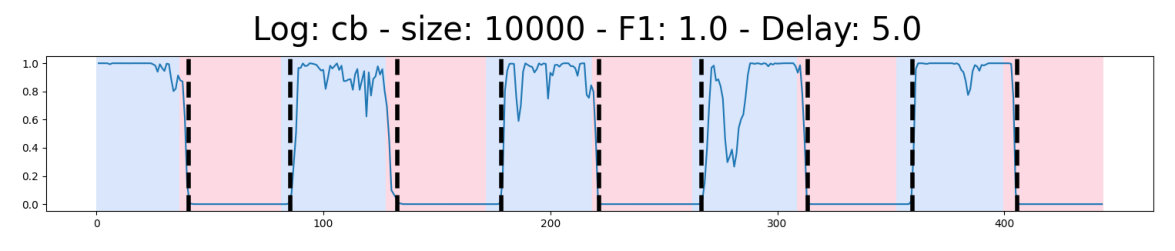

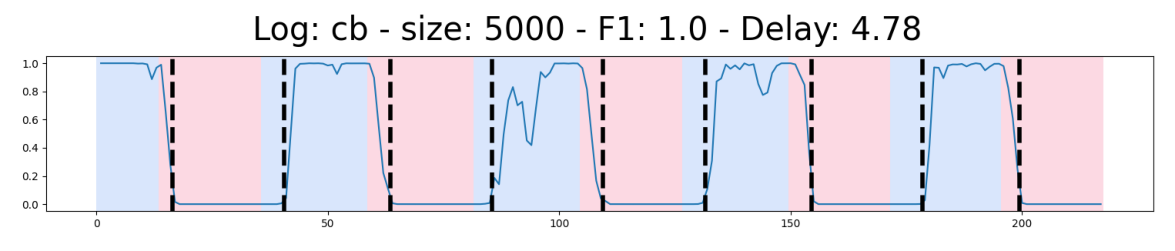

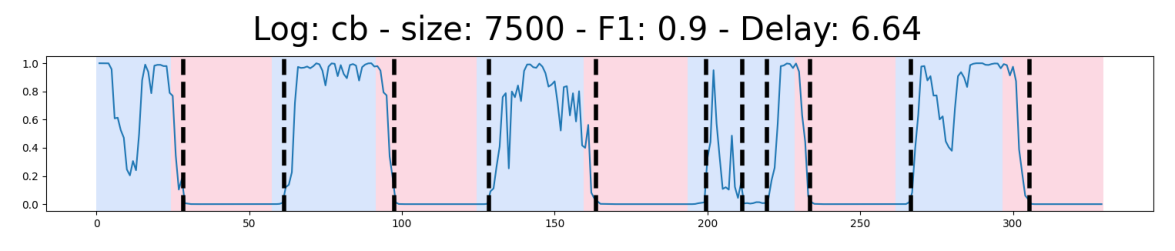

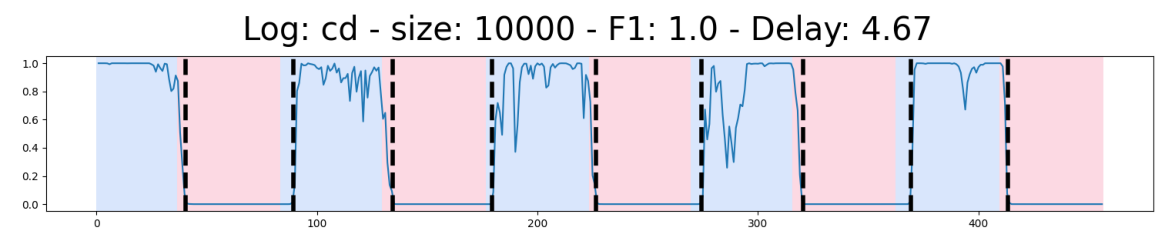

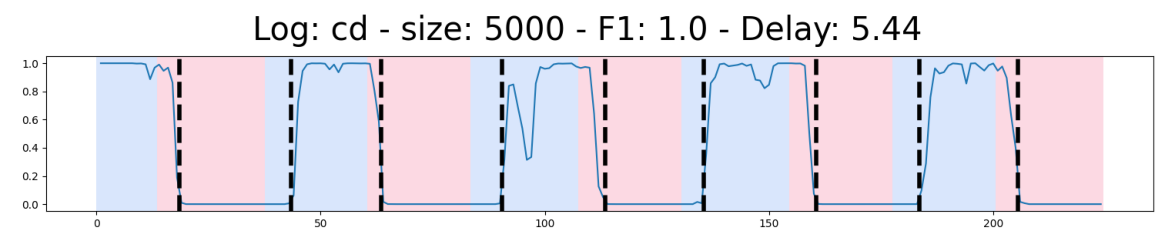

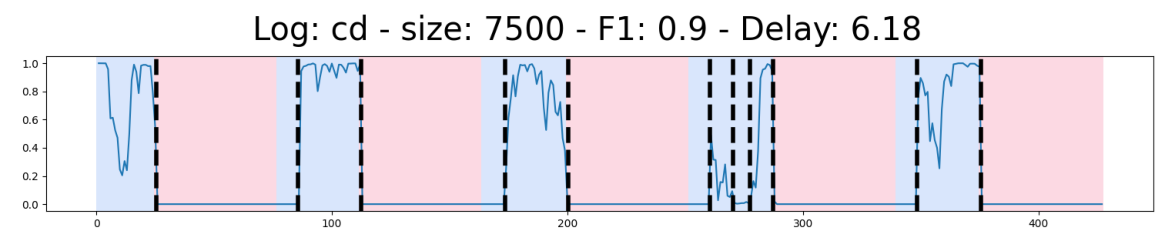

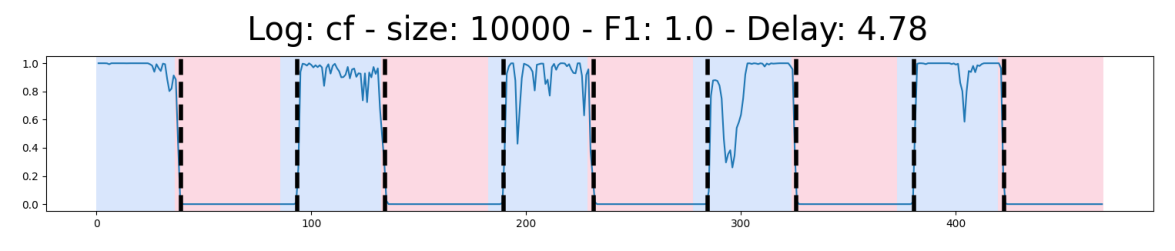

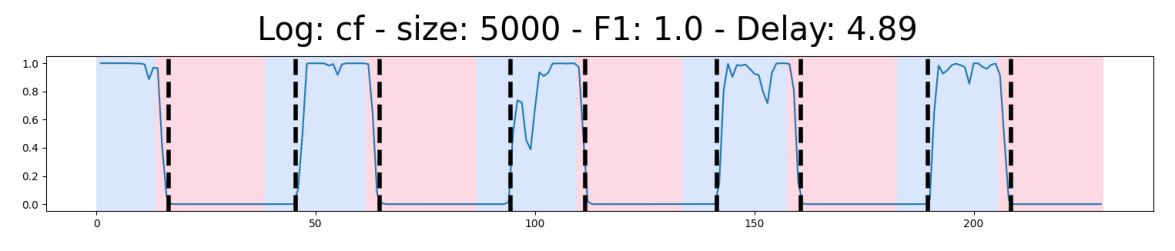

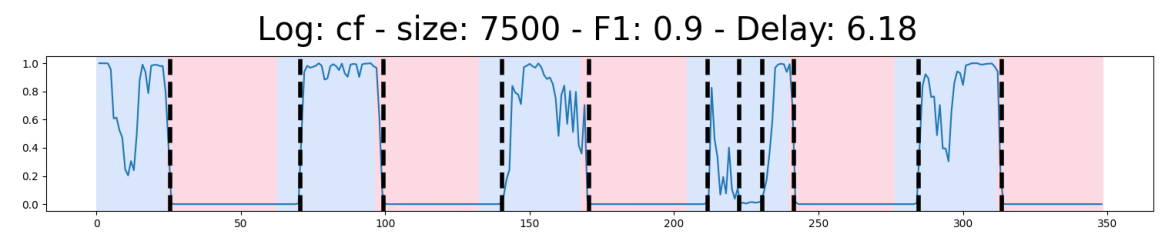

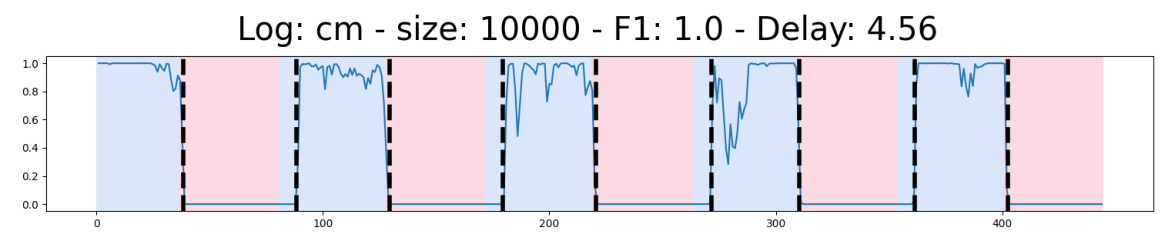

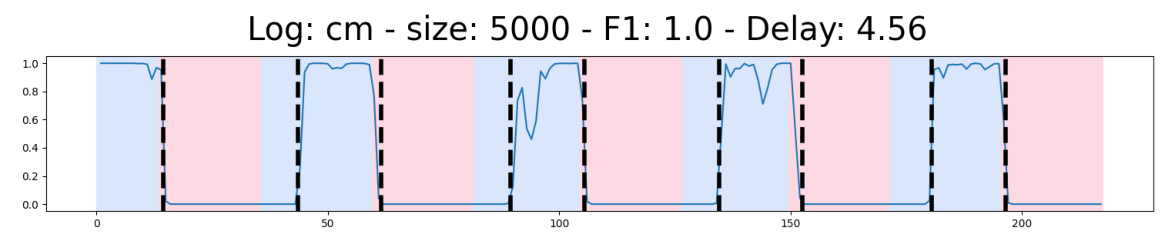

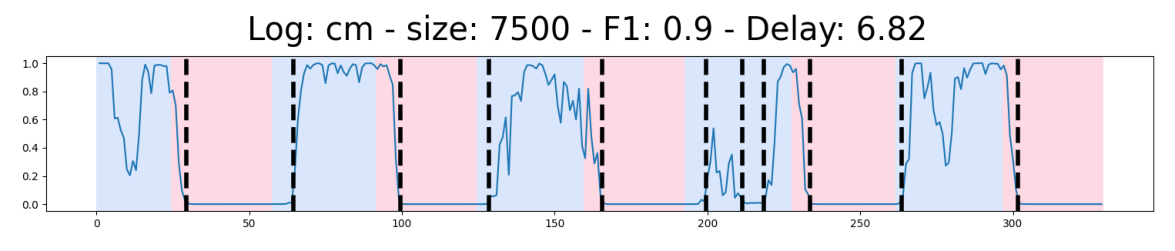

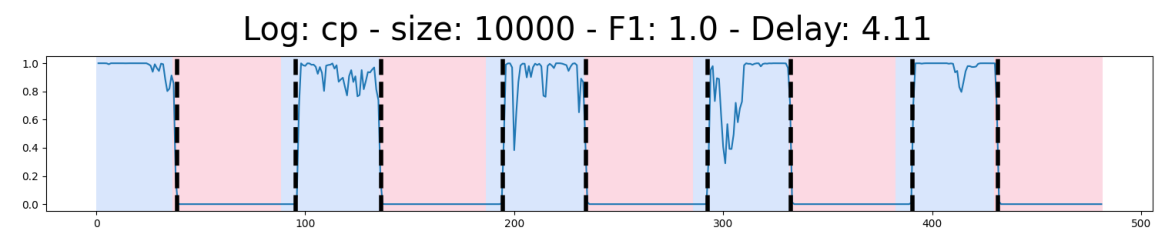

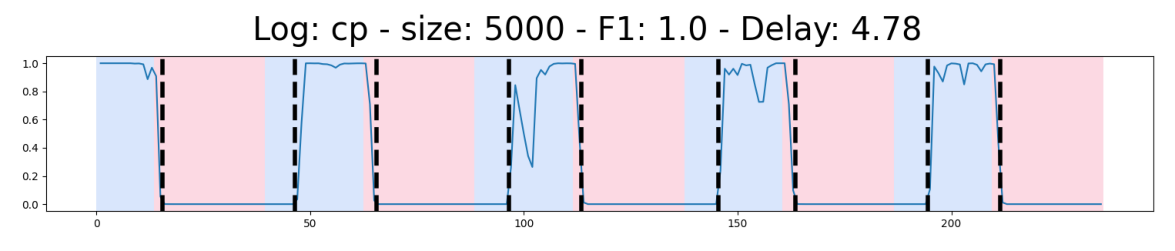

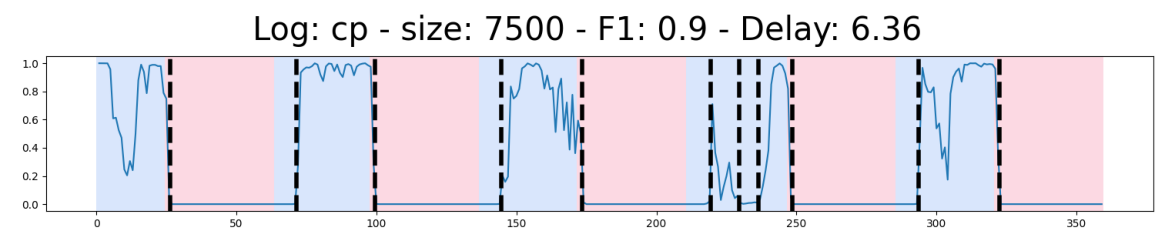

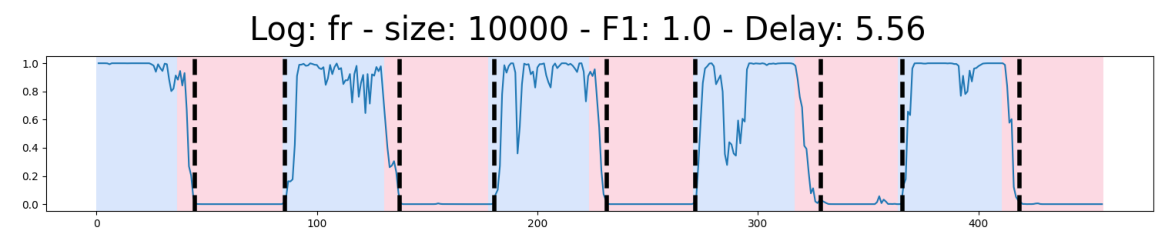

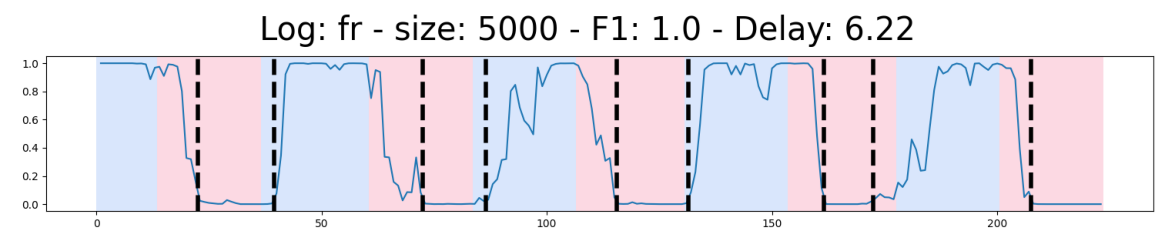

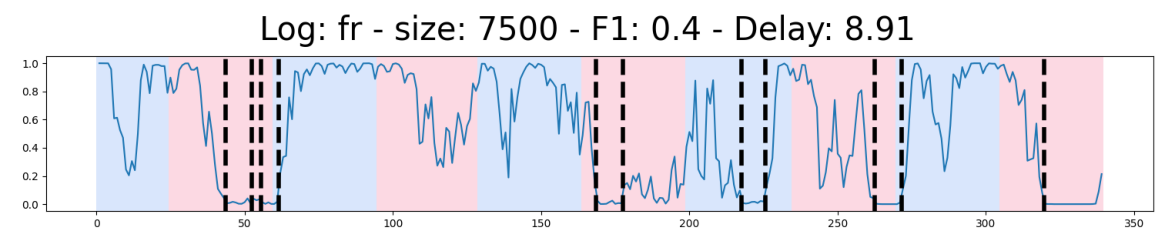

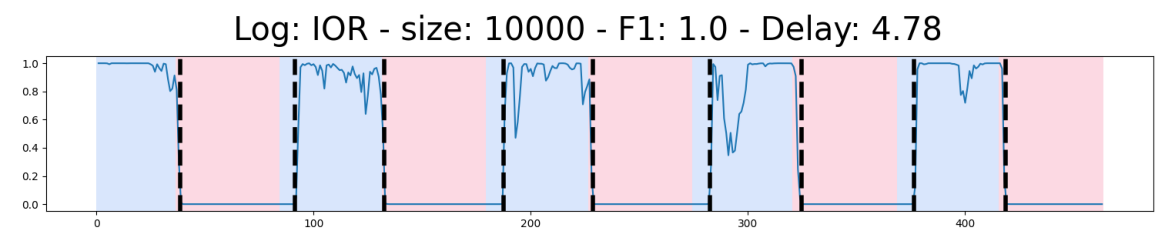

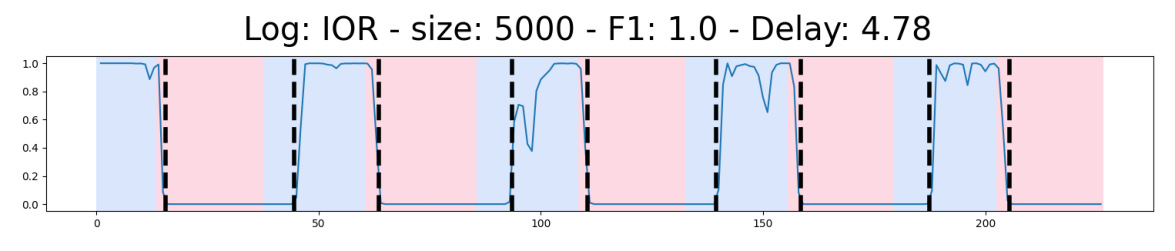

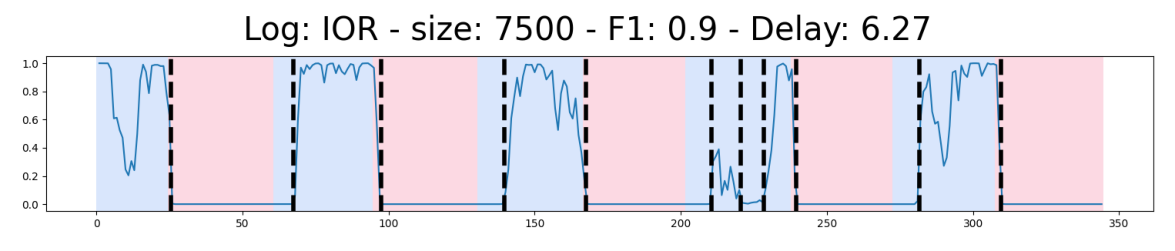

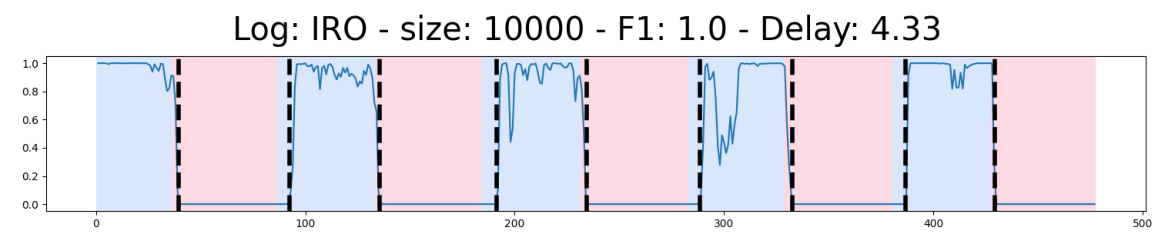

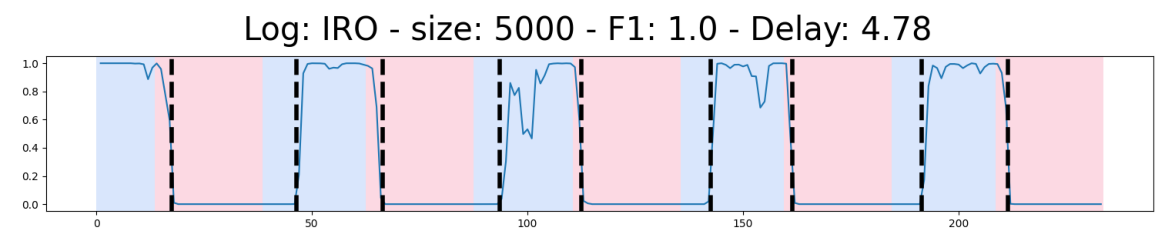

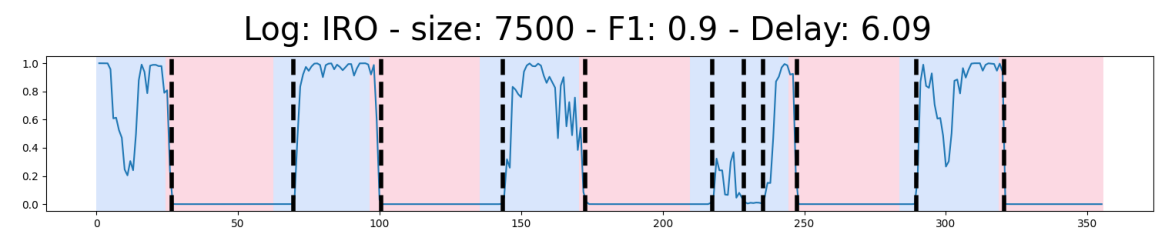

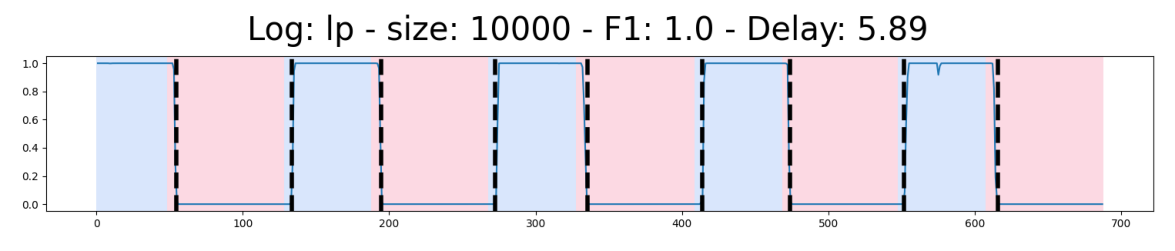

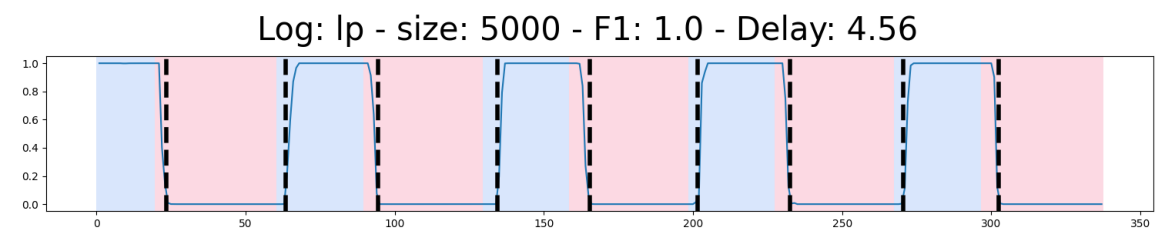

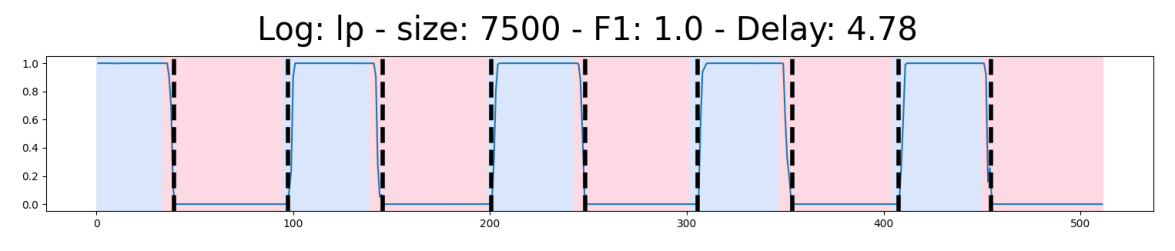

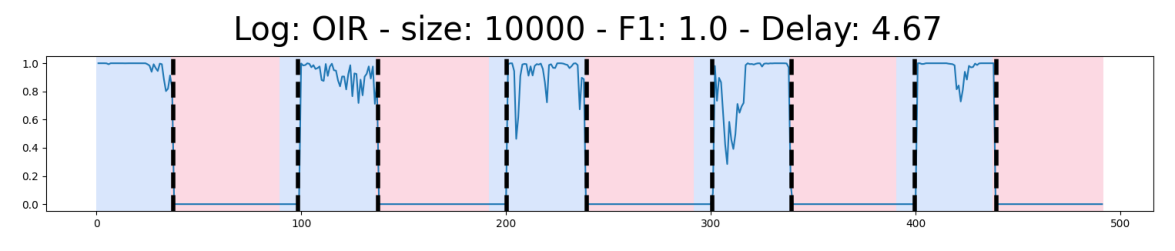

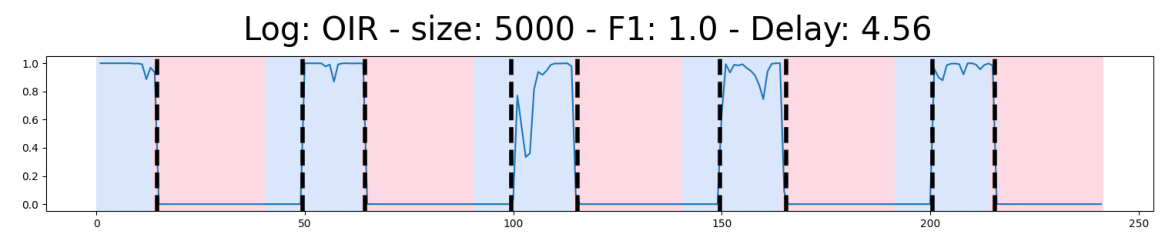

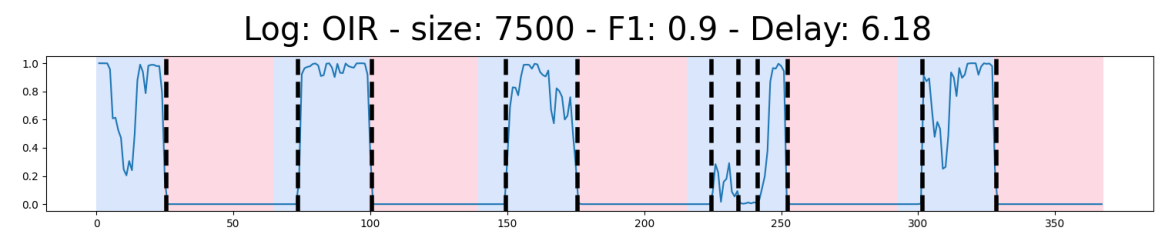

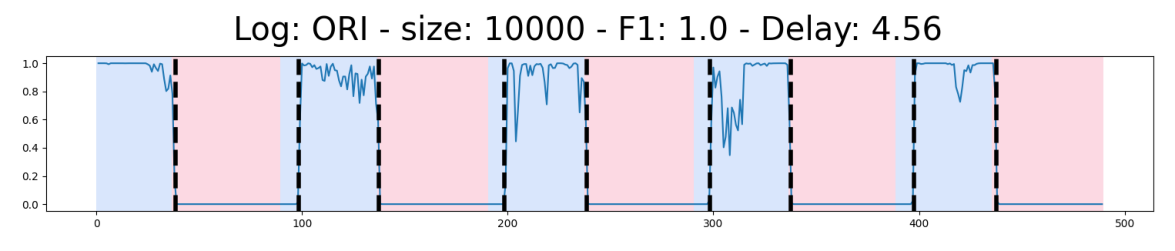

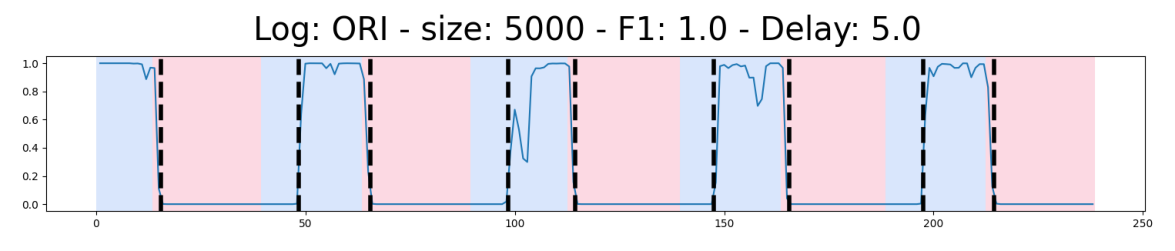

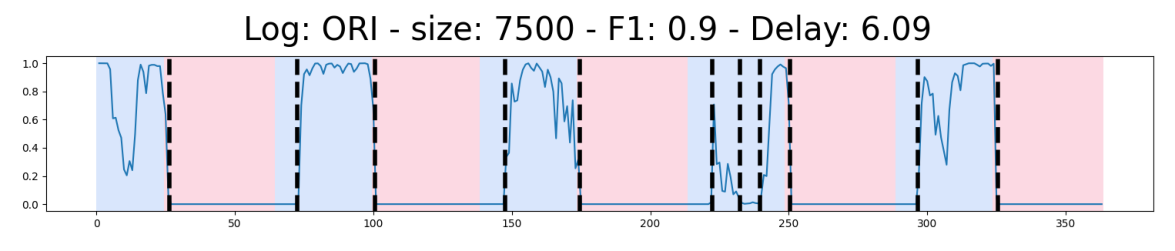

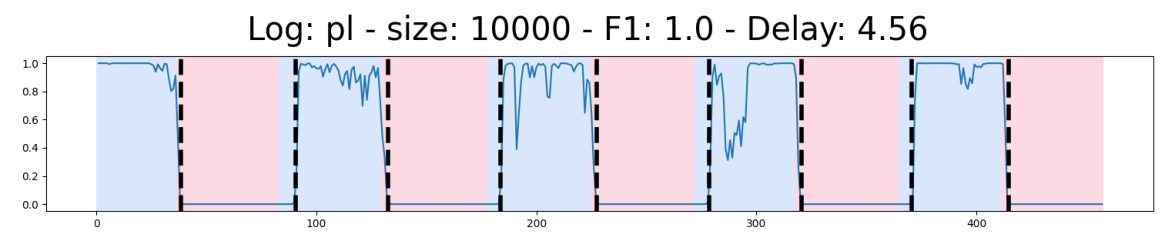

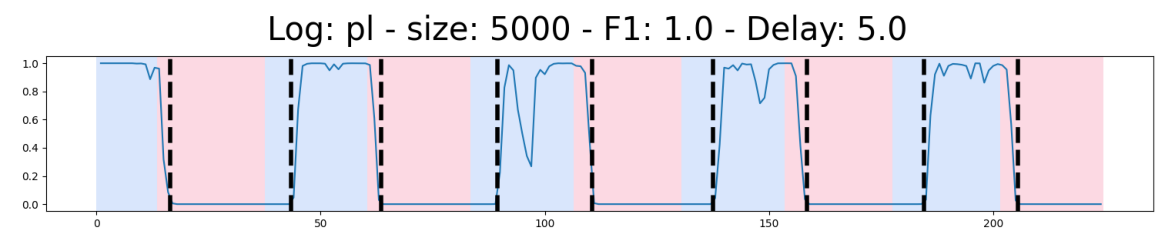

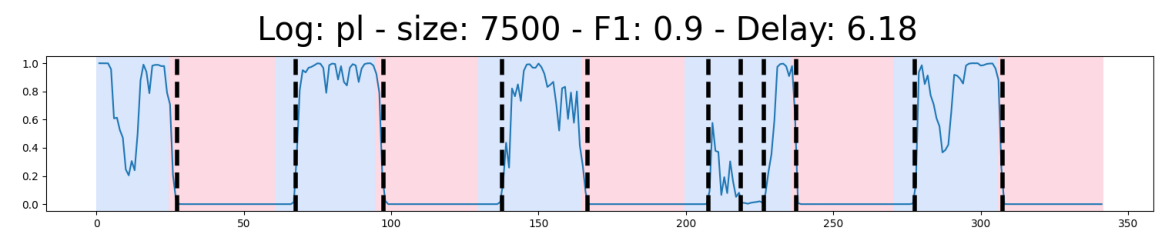

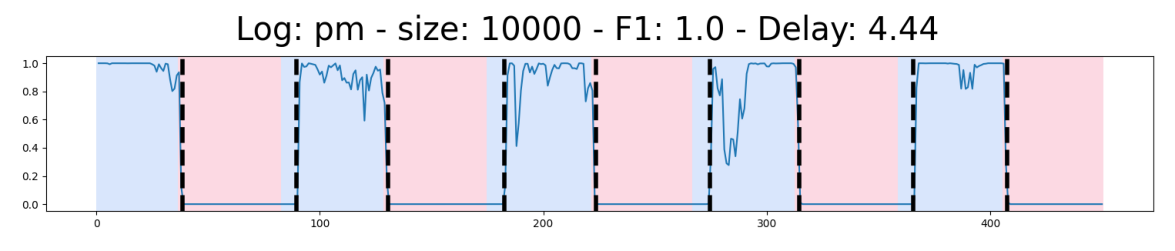

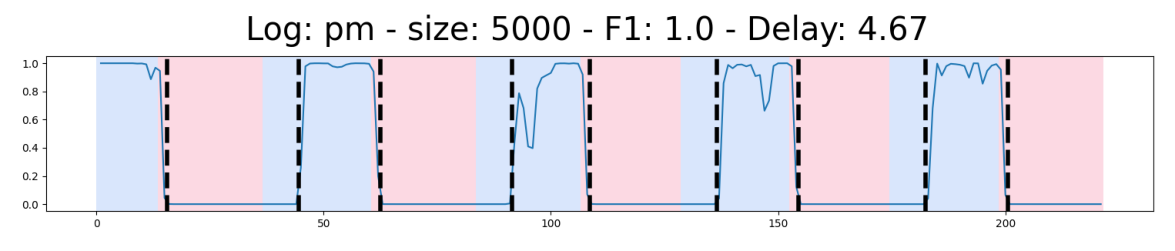

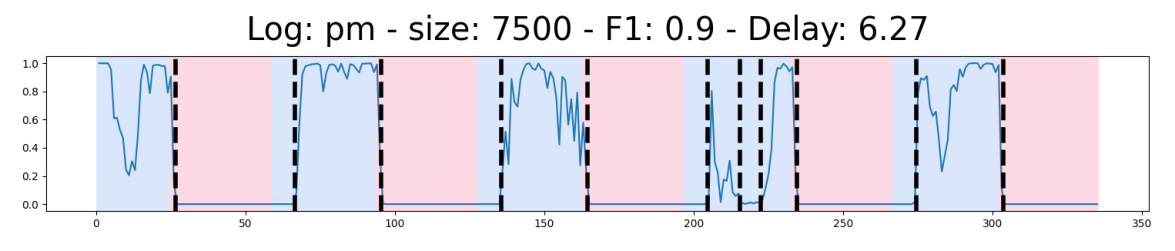

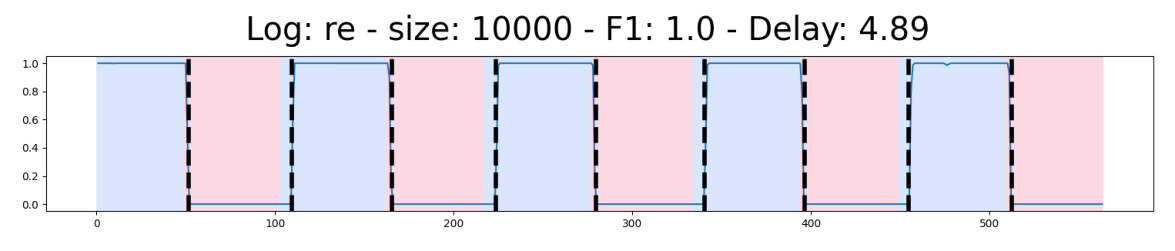

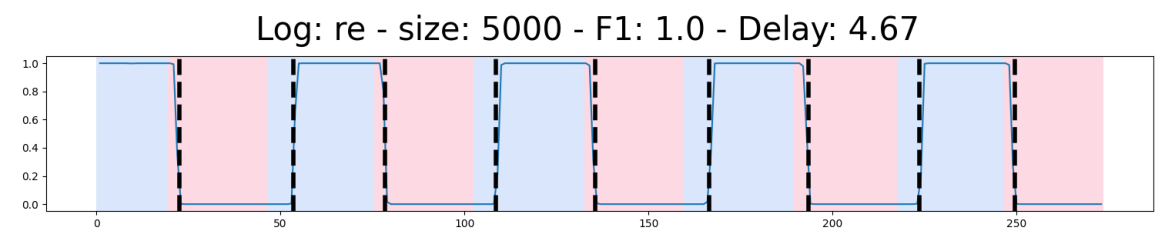

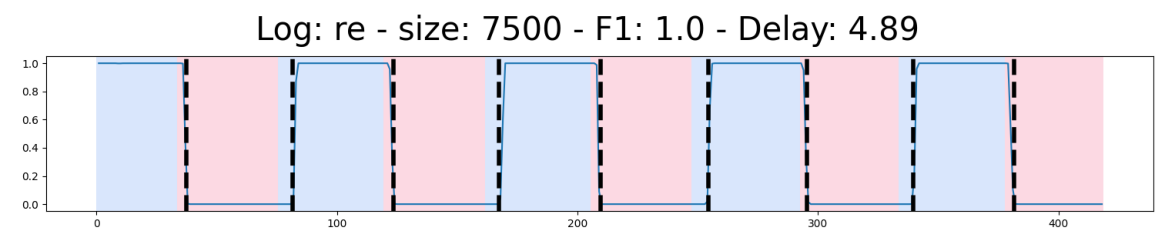

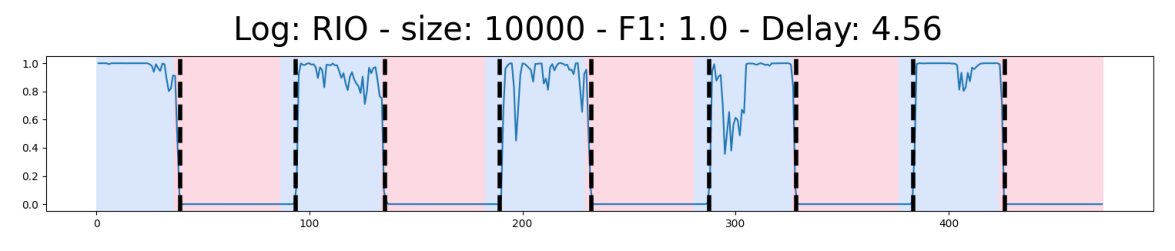

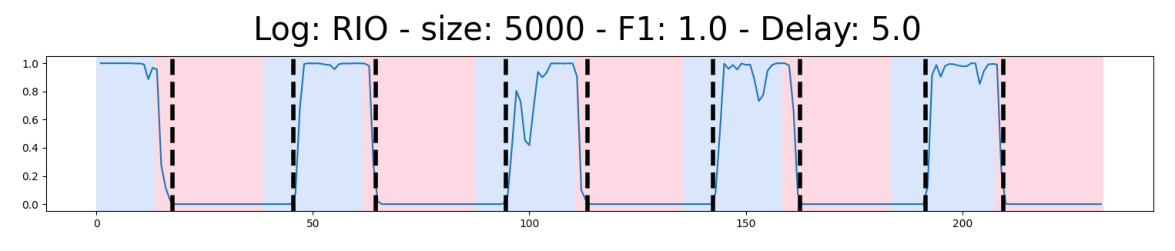

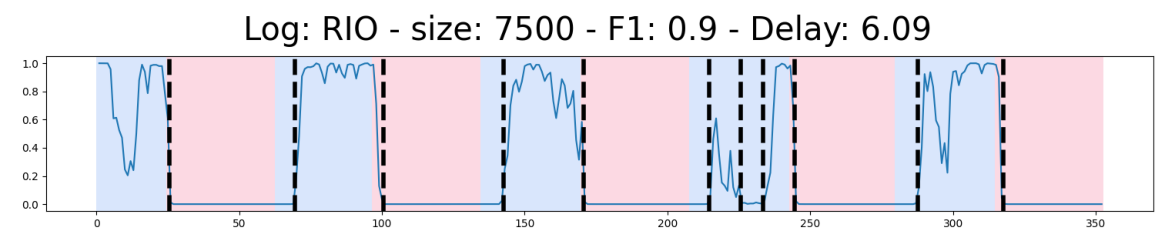

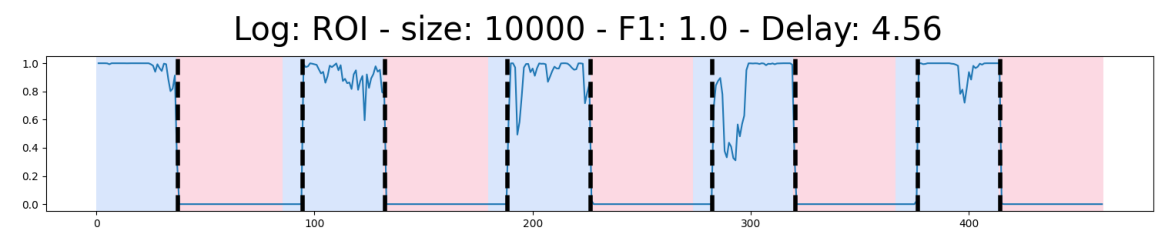

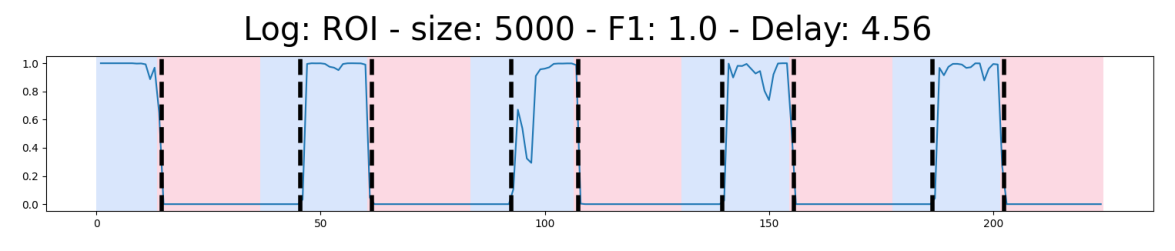

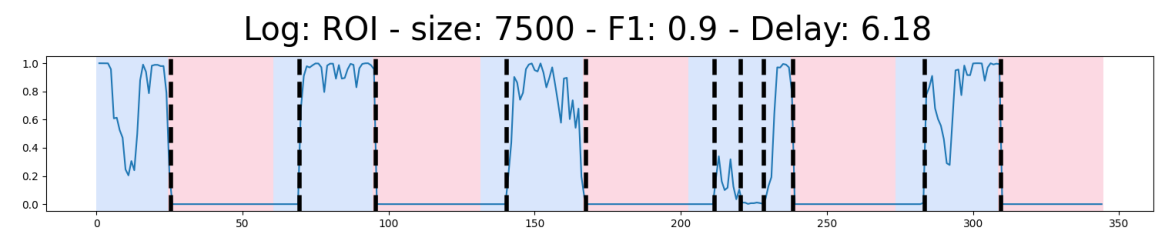

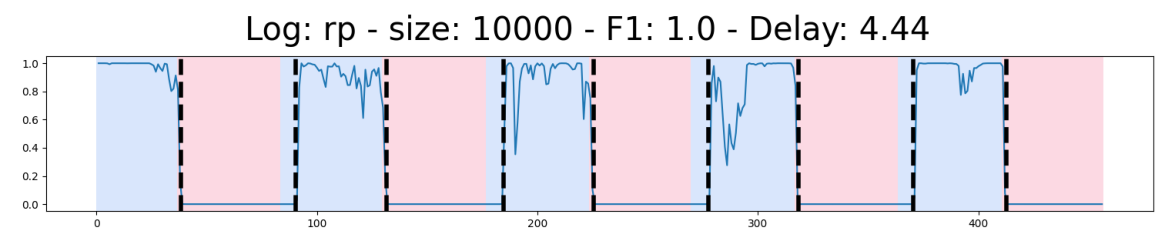

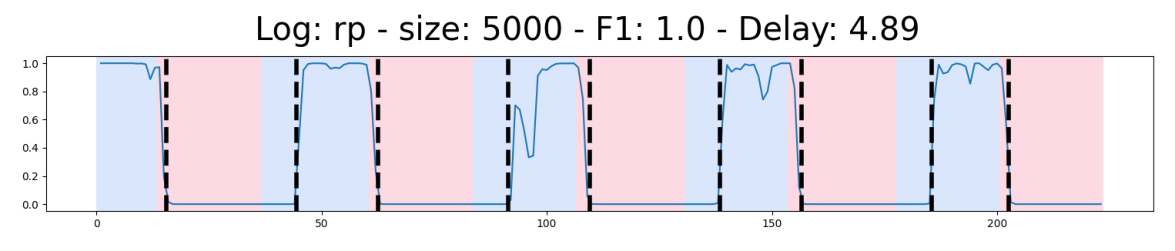

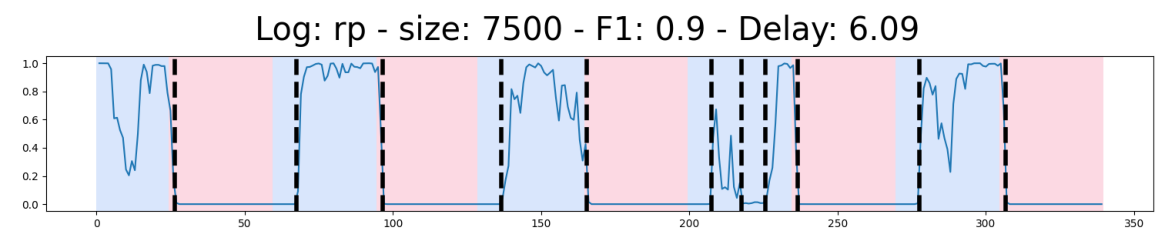

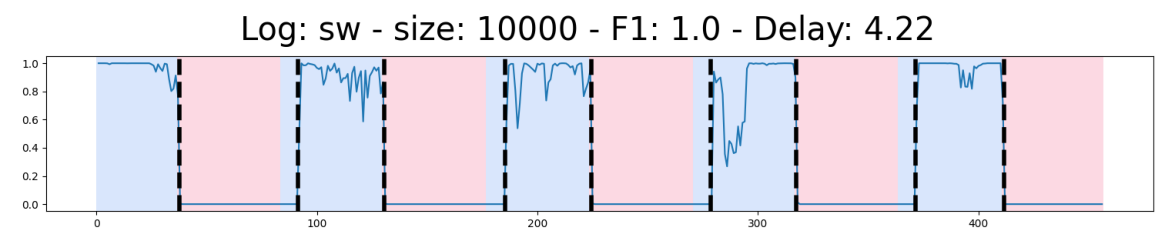

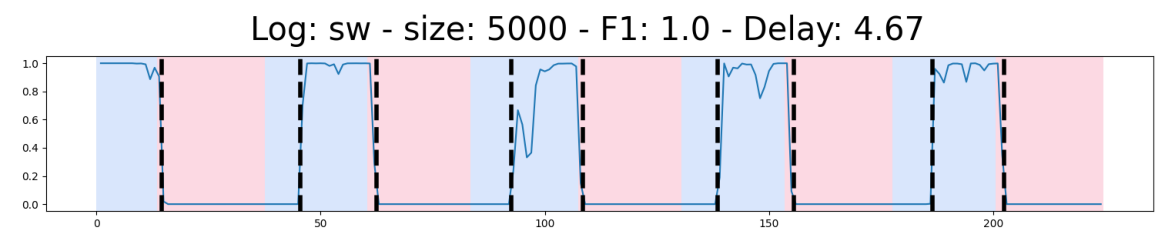

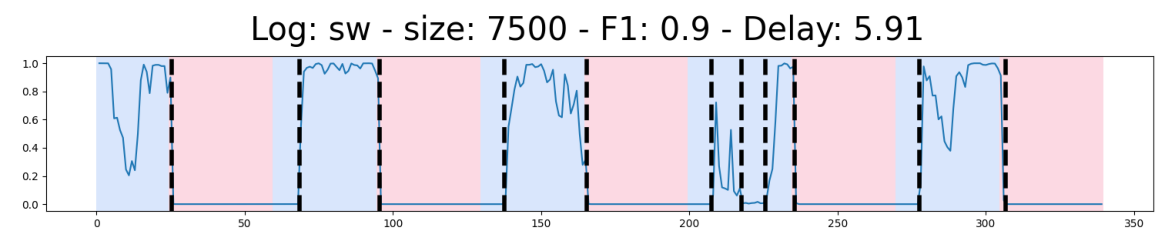

In [ ]:
for index, result in TMPD_experiment_logs_results_df.iterrows(): 
    fig, ax = plt.subplots(figsize=(15,3))
    plt.axis('off')
    ax.imshow(result['display'])
    plt.show()